In [5]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import readability


In [1]:
import cloudpickle
disease_lookup = cloudpickle.load(open("disease_lookup.pkl", "rb" ) )
disease_list = cloudpickle.load(open("disease_list.pkl", "rb" ) )
df_crop = cloudpickle.load(open("cleaned_forum_data.pkl", "rb" ) )


In [23]:
from nltk import ngrams
import string
from nltk.sentiment.util import mark_negation
import scipy.sparse as sps

all_lab= sps.lil_matrix((len(df_crop), len(disease_list)))
ask_lab= sps.lil_matrix((len(df_crop), len(disease_list)))
doc_lab= sps.lil_matrix((len(df_crop), len(disease_list)))
dcn_lab= sps.lil_matrix((len(df_crop), len(disease_list)))

def get_toks(txt,ngram_length):
    return [item for sublist in \
             [[" ".join(grams) for grams in ngrams(txt.split(), n)] \
             for n in range(ngram_length)] \
             for item in sublist]

# fuzzy matching is way too slow (takes roughly 400000x longer)
# from fuzzywuzzy import process
# def get_dislist(diseases,text_tok):
#     toreturn=[]
#     for k in diseases:
#         match =process.extractOne(k, text_tok)
#         if(match and match[1]>90 and 'NEG' not in match[0]):
#             toreturn.append(match[0])
#     return toreturn

# this is the easy way to search, it will miss a lot, but it will work for now
def get_dislist_simple(diseases,text):
    choptext=dict([[a,0] for a in get_toks(text,4)])
    return [k for k in diseases if k in choptext]

# def get_dislist_simple(diseases,text):
#     return [k for k in diseases if k in text]

# loop over all posts to perform the text analysis for labeling
for i,post in enumerate(df_crop['post'].values):
    if(i%1000==0):
        print i
    ask = df_crop.loc[df_crop['post']==post,'askertxt'].values[0].lower()
    doc = df_crop.loc[df_crop['post']==post,'doctortxt'].values[0].lower()
    oth = df_crop.loc[df_crop['post']==post,'othertxt'].values[0].lower()
    
    asktxt = ask.translate(string.maketrans(string.punctuation, ' '*len(string.punctuation)))
    doctxt = doc.translate(string.maketrans(string.punctuation, ' '*len(string.punctuation)))
    dcntxt = mark_negation(doc).translate(string.maketrans(string.punctuation, ' '*len(string.punctuation)))
    alltxt = (ask+' '+doc+' '+oth).translate(string.maketrans(string.punctuation, ' '*len(string.punctuation)))
    
    alldiags = get_dislist_simple(disease_lookup.keys(),alltxt)
    askdiags = get_dislist_simple(alldiags,asktxt)
    docdiags = get_dislist_simple(alldiags,doctxt)
    dcndiags = get_dislist_simple(docdiags,dcntxt)
    
    #better way to solve the problem, but will take roughly a year to finish (aaaahh)
#     ask_tok=get_toks(asktxt,3)
#     doc_tok=get_toks(doctxt,3)
#     dcn_tok=get_toks(dcntxt,3)
#     all_tok=get_toks(alltxt,3)
    
#     alldiags=get_dislist(disease_lookup.keys(),all_tok)
#     askdiags=get_dislist(alldiags,ask_tok)
#     docdiags=get_dislist(alldiags,doc_tok)
#     dcndiags=get_dislist(docdiags,dcn_tok)
    
    all_lab[i,list(set([disease_lookup[x] for x in alldiags]))]=1
    ask_lab[i,list(set([disease_lookup[x] for x in askdiags]))]=1
    doc_lab[i,list(set([disease_lookup[x] for x in docdiags]))]=1
    dcn_lab[i,list(set([disease_lookup[x] for x in dcndiags]))]=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000


In [3]:
all_lab = cloudpickle.load(open("alltext_labels.pkl", "rb" ) )
doc_lab = cloudpickle.load(open("doctortext_labels.pkl", "rb" ) )
dcn_lab = cloudpickle.load(open("doctornegtext_labels.pkl", "rb" ) )
ask_lab = cloudpickle.load(open("askertext_labels.pkl", "rb" ) )


In [ ]:
# all_lab = all_lab.asformat('csr')
# doc_lab = doc_lab.asformat('csr')
# dcn_lab = dcn_lab.asformat('csr')
# ask_lab = ask_lab.asformat('csr')

In [9]:
import numpy as np
disease_list = cloudpickle.load(open("disease_list.pkl", "rb" ) )

min_appear=100

disease_list_trunc=[disease_list[i] for i in np.where(all_lab.sum(axis=0)>min_appear)[1].tolist()]
disease_lookup_trunc={}
for i,dis in enumerate(disease_list_trunc):
    for s in dis[2]:
        disease_lookup_trunc[s]=i

doc_lab = doc_lab[:,np.array(all_lab.sum(axis=0)>min_appear).flatten()]
dcn_lab = dcn_lab[:,np.array(all_lab.sum(axis=0)>min_appear).flatten()]
ask_lab = ask_lab[:,np.array(all_lab.sum(axis=0)>min_appear).flatten()]
all_lab = all_lab[:,np.array(all_lab.sum(axis=0)>min_appear).flatten()]

In [10]:
doc_lab.shape

(63846, 72)

# Saving everything to the production ready state
only need to add stats and the classification

In [11]:
import cloudpickle
with open("alltext_labels.pkl", 'wb') as handle:
    cloudpickle.dump(all_lab, handle)
with open("doctortext_labels.pkl", 'wb') as handle:
    cloudpickle.dump(doc_lab, handle)
with open("doctornegtext_labels.pkl", 'wb') as handle:
    cloudpickle.dump(dcn_lab, handle)
with open("askertext_labels.pkl", 'wb') as handle:
    cloudpickle.dump(ask_lab, handle)
with open("disease_list.pkl", 'wb') as handle:
    cloudpickle.dump(disease_list_trunc, handle)
with open("disease_lookup.pkl", 'wb') as handle:
    cloudpickle.dump(disease_lookup_trunc, handle)

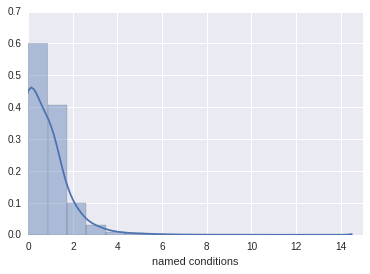

In [21]:
dc=doc_lab.asformat('csr')
todc=dc.sum(axis=1)
sns.distplot(todc[ (todc < 15)],15,kde_kws={'bw':0.5})
plt.xlim(0, 15)
plt.xlabel("named conditions")
# sns.distplot(ak.sum(axis=0),100)

('acne',
 'http://www.mayoclinic.org/diseases-conditions/diseases-conditions/acne/basics/definition/con-20020580',
 ['acne', 'baby acne'])